<a href="https://colab.research.google.com/github/Krishna4123/amdl/blob/main/stock_priceCb127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training model for: AMZN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1520 non-null   datetime64[ns]
 1   AMZN           1520 non-null   float64       
 2   DPZ            1520 non-null   float64       
 3   BTC            1520 non-null   float64       
 4   NFLX           1520 non-null   float64       
 5   AMZN_ret       1519 non-null   float64       
 6   AMZN_vol       1510 non-null   float64       
 7   AMZN_MA7       1514 non-null   float64       
 8   AMZN_MA20      1501 non-null   float64       
 9   AMZN_MA50      1471 non-null   float64       
 10  AMZN_momentum  1513 non-null   float64       
 11  AMZN_lag1      1519 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 142.6 KB

Training model for: DPZ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 

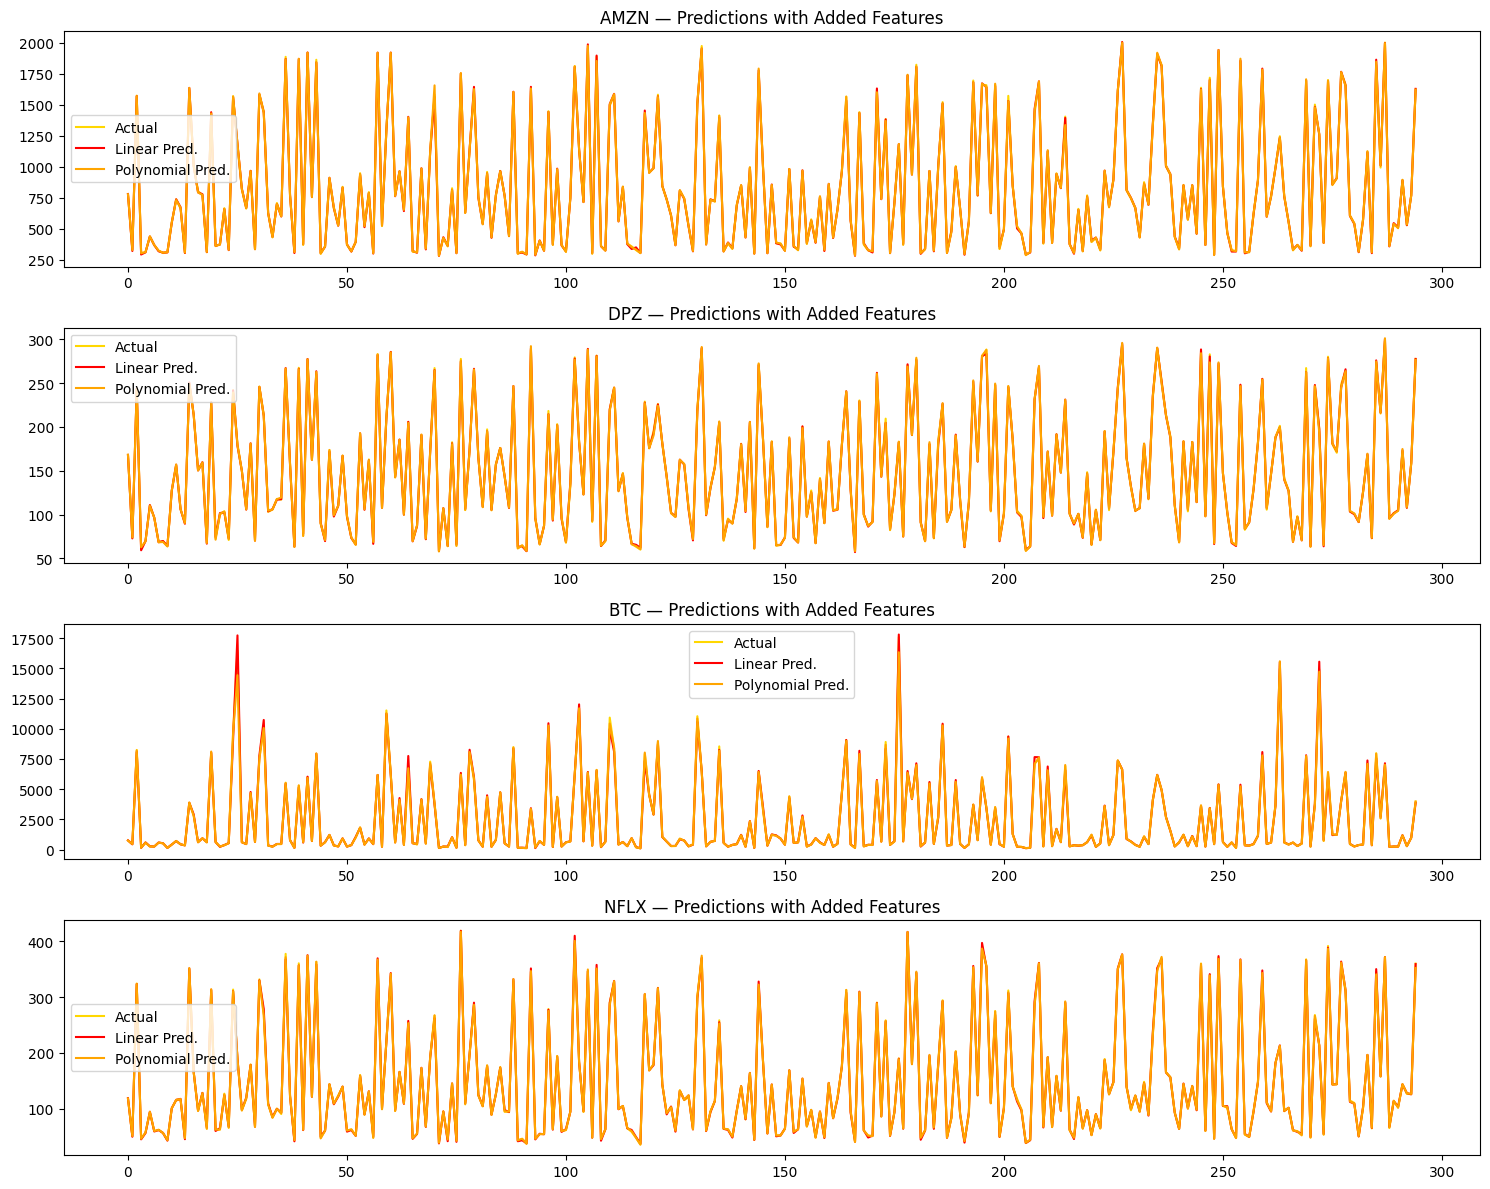


===== MODEL PERFORMANCE (WITH TECHNICAL INDICATORS) =====
  Stock  Linear_RMSE   Poly_RMSE  Linear_R2   Poly_R2  Linear_Accuracy  \
0  AMZN     9.701528    9.997597   0.999635  0.999612         0.989796   
1   DPZ     1.330390    1.389311   0.999639  0.999606         0.996599   
2   BTC   162.585248  153.683434   0.997582  0.997839         0.982993   
3  NFLX     2.433630    1.617683   0.999468  0.999765         0.989796   

   Poly_Accuracy  
0       0.996599  
1       0.996599  
2       0.996599  
3       0.996599  


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split


df = pd.read_csv("portfolio_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

stocks = ["AMZN", "DPZ", "BTC", "NFLX"]
results = []

plt.figure(figsize=(15, 12))
plot_index = 1

for stock in stocks:
    print("\n==============================")
    print(f"Training model for: {stock}")
    print("==============================")

    # Original series
    series = df[stock].astype(float)


    # 1. Daily Returns
    df[f"{stock}_ret"] = df[stock].pct_change()

    # 2. Volatility (10-day rolling std)
    df[f"{stock}_vol"] = df[f"{stock}_ret"].rolling(window=10).std()

    # 3. Moving Averages (trend features)
    df[f"{stock}_MA7"]  = df[stock].rolling(window=7).mean()
    df[f"{stock}_MA20"] = df[stock].rolling(window=20).mean()
    df[f"{stock}_MA50"] = df[stock].rolling(window=50).mean()

    # 4. Momentum (price change over 7 days)
    df[f"{stock}_momentum"] = df[stock].diff(7)

    # 5. Lag features (yesterday's price)
    df[f"{stock}_lag1"] = df[stock].shift(1)

    # Build the feature list
    feature_cols = [
        f"{stock}_lag1",
        f"{stock}_ret",
        f"{stock}_vol",
        f"{stock}_MA7",
        f"{stock}_MA20",
        f"{stock}_MA50",
        f"{stock}_momentum",
    ]

    # Remove rows with NaN created by rolling windows
    df_features = df[feature_cols].dropna()
    X = df_features.values


    noise_level = 0.01  # 1% noise
    noise = np.random.normal(0, noise_level, X.shape)

# Add noise only to X (not to target y)
    X = X + noise

# Align y (target)
    y = df[stock].iloc[-len(X):].values

    df.info()
    df.head()
    df.describe()
    df.tail()

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

    # -----------------------------
    # Linear Regression
    # -----------------------------
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    lin_pred = lin_model.predict(X_test)

    lin_mse = mean_squared_error(y_test, lin_pred)
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(y_test, lin_pred)
    lin_r2 = r2_score(y_test, lin_pred)
    lin_acc = accuracy_score(np.sign(np.diff(y_test)), np.sign(np.diff(lin_pred)))

    # -----------------------------
    # Polynomial Regression (degree 3)
    # -----------------------------
    poly = PolynomialFeatures(degree=3)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    poly_pred = poly_model.predict(X_test_poly)

    poly_mse = mean_squared_error(y_test, poly_pred)
    poly_rmse = np.sqrt(poly_mse)
    poly_mae = mean_absolute_error(y_test, poly_pred)
    poly_r2 = r2_score(y_test, poly_pred)
    poly_acc = accuracy_score(np.sign(np.diff(y_test)), np.sign(np.diff(poly_pred)))

    # Save metrics
    results.append({
        "Stock": stock,
        "Linear_RMSE": lin_rmse,
        "Poly_RMSE": poly_rmse,
        "Linear_R2": lin_r2,
        "Poly_R2": poly_r2,
        "Linear_Accuracy": lin_acc,
        "Poly_Accuracy": poly_acc
    })

    # -----------------------------
    # Plot predictions
    # -----------------------------
    plt.subplot(4, 1, plot_index)
    plt.plot(y_test, label="Actual", color='gold')
    plt.plot(lin_pred, label="Linear Pred.", color='red')
    plt.plot(poly_pred, label="Polynomial Pred.", color='orange')
    plt.title(f"{stock} — Predictions with Added Features")
    plt.legend()
    plot_index += 1

plt.tight_layout()
plt.show()

# Show results
results_df = pd.DataFrame(results)
print("\n===== MODEL PERFORMANCE (WITH TECHNICAL INDICATORS) =====")
print(results_df)


In [12]:
print("\n==============================")
print("      FUTURE PRICE PREDICTION")
print("==============================")

# Ask the user for a stock name
user_stock = input("\nEnter stock name (AMZN / DPZ / BTC / NFLX): ").upper()

if user_stock not in stocks:
    print("❌ Invalid stock name entered.")
else:
    # Ask for yesterday's price
    try:
        last_price = float(input(f"Enter yesterday's price for {user_stock}: "))
    except:
        print("❌ Invalid price entered.")
        exit()

    # Build input feature vector using latest technical indicators
    row = {
        f"{user_stock}_lag1": last_price,
        f"{user_stock}_ret": df[f"{user_stock}_ret"].iloc[-1],
        f"{user_stock}_vol": df[f"{user_stock}_vol"].iloc[-1],
        f"{user_stock}_MA7": df[f"{user_stock}_MA7"].iloc[-1],
        f"{user_stock}_MA20": df[f"{user_stock}_MA20"].iloc[-1],
        f"{user_stock}_MA50": df[f"{user_stock}_MA50"].iloc[-1],
        f"{user_stock}_momentum": df[f"{user_stock}_momentum"].iloc[-1]
    }

    # Convert to array for model prediction
    input_features = np.array(list(row.values())).reshape(1, -1)

    # Linear Regression prediction
    linear_future_price = lin_model.predict(input_features)[0]

    # Polynomial Regression prediction
    poly_input = poly.transform(input_features)
    poly_future_price = poly_model.predict(poly_input)[0]

    print("\n==============================")
    print(f"📈 FUTURE PRICE PREDICTION FOR {user_stock}")
    print("==============================")
    print(f"Linear Regression Prediction   : {linear_future_price:.2f}")
    print(f"Polynomial Regression Prediction: {poly_future_price:.2f}")
    print("==============================\n")



      FUTURE PRICE PREDICTION

Enter stock name (AMZN / DPZ / BTC / NFLX): AMZN
Enter yesterday's price for AMZN: 235

📈 FUTURE PRICE PREDICTION FOR AMZN
Linear Regression Prediction   : 667.04
Polynomial Regression Prediction: 237.25



Before Adding few Features like Volatility,MA7......,.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)

In [ ]:
df = pd.read_csv("portfolio_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

stocks = ["AMZN", "DPZ", "BTC", "NFLX"]
results = []

plt.figure(figsize=(15, 12))
plot_index = 1

<Figure size 1500x1200 with 0 Axes>

In [ ]:
for stock in stocks:
    print("\n==============================")
    print(f"Training model for: {stock}")
    print("==============================")

    series = df[stock].astype(float)

    # Lag-1 feature
    X = series.shift(1).dropna().values.reshape(-1, 1)
    y = series[1:].values

    # 80-20 split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # -----------------------------
    # Linear Regression
    # -----------------------------
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    lin_pred = lin_model.predict(X_test)

    # Metrics
    lin_mse = mean_squared_error(y_test, lin_pred)
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(y_test, lin_pred)
    lin_r2 = r2_score(y_test, lin_pred)

    # Direction accuracy (up/down)
    lin_acc = accuracy_score(
        np.sign(np.diff(y_test)),
        np.sign(np.diff(lin_pred))
    )



Training model for: AMZN

Training model for: DPZ

Training model for: BTC

Training model for: NFLX


In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_test_poly)

    # Metrics
poly_mse = mean_squared_error(y_test, poly_pred)
poly_rmse = np.sqrt(poly_mse)
poly_mae = mean_absolute_error(y_test, poly_pred)
poly_r2 = r2_score(y_test, poly_pred)
poly_acc = accuracy_score(
    np.sign(np.diff(y_test)),
    np.sign(np.diff(poly_pred))
)

    # Save in results table
results.append({
        "Stock": stock,
        "Linear_RMSE": lin_rmse,
        "Poly_RMSE": poly_rmse,
        "Linear_R2": lin_r2,
        "Poly_R2": poly_r2,
        "Linear_Accuracy": lin_acc,
        "Poly_Accuracy": poly_acc
})

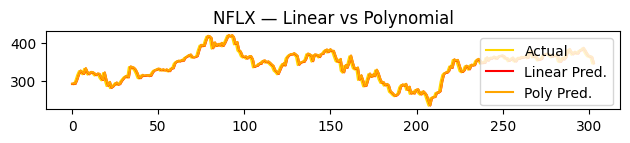

In [ ]:
plt.subplot(4, 1, plot_index)
plt.plot(y_test, label="Actual", color='gold')
plt.plot(lin_pred, label="Linear Pred.", color='red')
plt.plot(poly_pred, label="Poly Pred.", color='orange')
plt.title(f"{stock} — Linear vs Polynomial")
plt.legend()
plot_index += 1

plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame(results)
print("\n===== MODEL PERFORMANCE =====")
print(results_df)


===== MODEL PERFORMANCE =====
  Stock  Linear_RMSE  Poly_RMSE  Linear_R2   Poly_R2  Linear_Accuracy  \
0  NFLX     9.023669   9.146037   0.939928  0.938287         0.452145   

   Poly_Accuracy  
0       0.452145  


In [ ]:
print("\n==============================")
print("  FUTURE PRICE PREDICTION")
print("==============================\n")

user_stock = input("Enter stock name (AMZN / DPZ / BTC / NFLX): ").upper()

if user_stock not in stocks:
    print("Invalid stock name.")
else:
    last_price = float(input(f"Enter yesterday's price for {user_stock}: "))

    # Linear prediction
    lin_future = lin_model.predict([[last_price]])

    # Polynomial prediction
    poly_future = poly_model.predict(poly.transform([[last_price]]))

    print(f"\nPredicted next-day price of {user_stock}:")
    print(f"Linear Regression Prediction   : {lin_future[0]:.2f}")
    print(f"Polynomial Regression Prediction: {poly_future[0]:.2f}")


  FUTURE PRICE PREDICTION

Enter stock name (AMZN / DPZ / BTC / NFLX): AMZN
Enter yesterday's price for AMZN: 234

Predicted next-day price of AMZN:
Linear Regression Prediction   : 234.66
Polynomial Regression Prediction: 235.03
